In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

import os
from tqdm import tqdm

from pathlib import Path

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df = pd.read_csv('/kaggle/input/rsna-2022-spine-fracture-detection-metadata/meta_segmentation_clean.csv')
df.head()

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10633,1,512,512,1.0,-68.0,98.0,314.099976,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10633,2,512,512,1.0,-68.0,98.0,313.599976,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10633,3,512,512,1.0,-68.0,98.0,313.099976,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.10633,4,512,512,1.0,-68.0,98.0,312.599976,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.10633,5,512,512,1.0,-68.0,98.0,312.099976,0,0,0,0,0,0,0


In [3]:
dicom_path = Path('/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images')

In [4]:
df_grouped = df.groupby('StudyInstanceUID').agg({'Slice' : 'max', 'SliceThickness' : 'max', 'C1' : 'sum', 'C2' : 'sum', 'C3' : 'sum',
                                    'C4' : 'sum', 'C5' : 'sum', 'C6' : 'sum', 'C7' : 'sum'}).reset_index(drop=False)
for i in range(1, 8):
    df_grouped[f'C{i}_low'] = df_grouped['StudyInstanceUID'].apply(lambda x: df[(df.StudyInstanceUID == x) & (df[f'C{i}'] == 1)]['Slice'].min())
    df_grouped[f'C{i}_high'] = df_grouped['StudyInstanceUID'].apply(lambda x: df[(df.StudyInstanceUID == x) & (df[f'C{i}'] == 1)]['Slice'].max())
    
df_grouped['TotalSlices'] = df_grouped['StudyInstanceUID'].apply(lambda uid: len(os.listdir(dicom_path / uid)))
df_grouped.head()

,StudyInstanceUID,Slice,SliceThickness,C1,C2,C3,C4,C5,C6,C7,...,C3_high,C4_low,C4_high,C5_low,C5_high,C6_low,C6_high,C7_low,C7_high,TotalSlices
0,1.2.826.0.1.3680043.10633,429,1.000,55,72,54,55,52,50,57,...,228,202,256,232,283,254,303,277,333,429
1,1.2.826.0.1.3680043.10921,339,0.625,42,64,40,40,39,44,44,...,143,130,169,156,194,175,218,203,246,339
2,1.2.826.0.1.3680043.11827,208,1.000,25,42,27,29,32,37,42,...,107,98,126,112,143,122,158,132,173,208
3,1.2.826.0.1.3680043.11988,217,1.000,35,58,34,27,32,32,38,...,122,109,135,126,157,145,176,158,195,217
4,1.2.826.0.1.3680043.12281,331,0.625,42,78,39,45,50,52,66,...,172,162,206,187,236,213,264,229,294,331


In [5]:
# Чекнул, если meta_segmentation_clean не входят некоторые Slice (например те, что идут после C7)
np.sum(np.abs(df_grouped['Slice'] - df_grouped['TotalSlices']))

1

Text(0.5, 1.0, 'Corr btw Slice & Slice Thickness and number of first slice with vertebra')

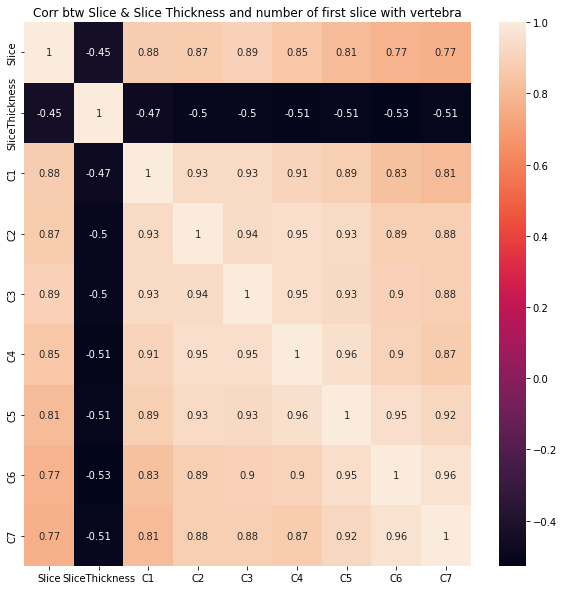

In [6]:
plt.rcParams['figure.figsize'] = (10, 10)
sns.heatmap(df_grouped.loc[:, ['Slice', 'SliceThickness'] + [f'C{i}' for i in range(1, 8)]].corr(), annot=True)
plt.title('Corr btw Slice & Slice Thickness and number of first slice with vertebra')

Text(0.5, 1.0, 'Corr btw Slice & Slice Thickness and number of first slice with vertebra')

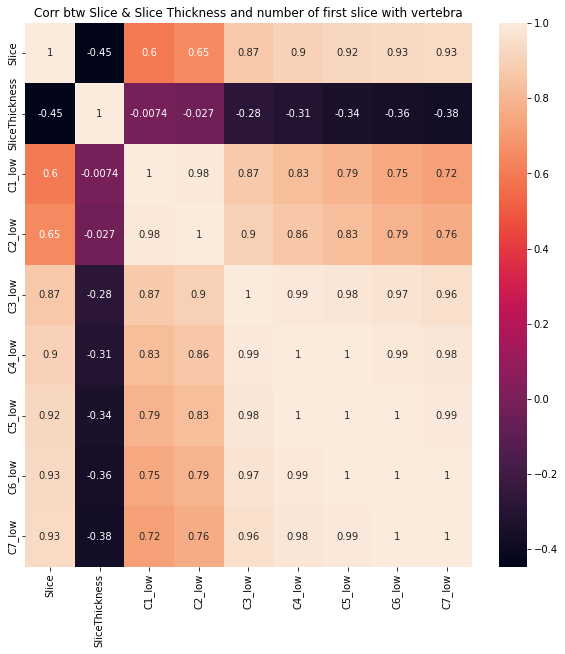

In [7]:
plt.rcParams['figure.figsize'] = (10, 10)
sns.heatmap(df_grouped.loc[:, ['Slice', 'SliceThickness'] + [f'C{i}_low' for i in range(1, 8)]].corr(), annot=True)
plt.title('Corr btw Slice & Slice Thickness and number of first slice with vertebra')

Text(0.5, 1.0, 'Corr btw Slice & Slice Thickness and number of last slice with vertebra')

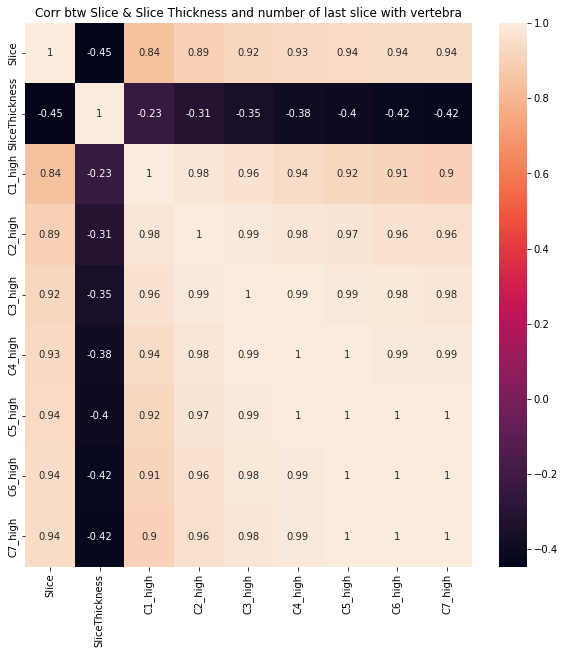

In [8]:
plt.rcParams['figure.figsize'] = (10, 10)
sns.heatmap(df_grouped.loc[:, ['Slice', 'SliceThickness'] + [f'C{i}_high' for i in range(1, 8)]].corr(), annot=True)
plt.title('Corr btw Slice & Slice Thickness and number of last slice with vertebra')

In [9]:
df_unlabeled = {'StudyInstanceUID' : [],
                'TotalSlices' : []}
for uid in tqdm(os.listdir(dicom_path)):
    #if uid not in np.unique(df_grouped.StudyInstanceUID):
    df_unlabeled['StudyInstanceUID'].append(uid)
    df_unlabeled['TotalSlices'].append(len(os.listdir(dicom_path / uid)))

100%|██████████| 2019/2019 [03:29<00:00,  9.62it/s]


In [10]:
df_unlabeled = pd.DataFrame(df_unlabeled)
df_unlabeled.head()

,StudyInstanceUID,TotalSlices
0,1.2.826.0.1.3680043.17625,239
1,1.2.826.0.1.3680043.3850,688
2,1.2.826.0.1.3680043.2286,333
3,1.2.826.0.1.3680043.14435,618
4,1.2.826.0.1.3680043.3442,336


In [11]:
!pip install mlinsights

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 7.0 MB/s eta 0:00:00


In [12]:
from mlinsights.mlmodel import QuantileLinearRegression

plt.rcParams['figure.figsize'] = (10, 10)

for i in range(1, 8):
    for target in ['_low', '_high']:
        X_train = df_grouped['Slice'].to_numpy()
        y_train = df_grouped[f'C{i}' + target].to_numpy()

        if target == '_low':
            q = QuantileLinearRegression(quantile=0.05)
        else:
            q = QuantileLinearRegression(quantile=0.95)

        q.fit(X_train.reshape(-1, 1), y_train)
        df_unlabeled[f'C{i}' + target[:2] + 'b'] = q.predict(df_unlabeled['TotalSlices'].to_numpy().reshape(-1, 1)).astype(int)
        
df_unlabeled.head()

,StudyInstanceUID,TotalSlices,C1_lb,C1_hb,C2_lb,C2_hb,C3_lb,C3_hb,C4_lb,C4_hb,C5_lb,C5_hb,C6_lb,C6_hb,C7_lb,C7_hb
0,1.2.826.0.1.3680043.17625,239,30,96,35,122,72,137,90,158,109,180,123,198,143,220
1,1.2.826.0.1.3680043.3850,688,49,235,66,314,165,351,194,405,238,465,284,513,321,578
2,1.2.826.0.1.3680043.2286,333,34,125,41,162,92,182,112,210,136,240,157,264,180,295
3,1.2.826.0.1.3680043.14435,618,46,213,61,284,151,318,178,367,218,421,259,464,293,522
4,1.2.826.0.1.3680043.3442,336,34,126,41,164,93,183,113,212,137,242,158,266,181,297


In [13]:
df_unlabeled.shape

(2019, 16)

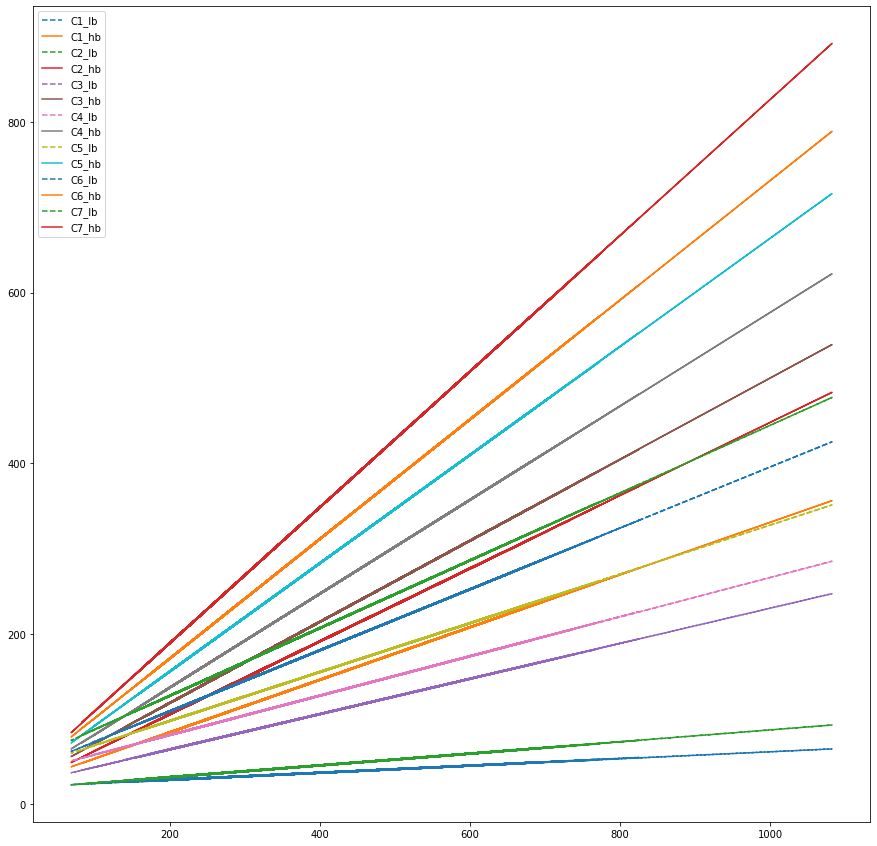

In [14]:
plt.rcParams['figure.figsize'] = (15, 15)

for i in range(1, 8):
    plt.plot(df_unlabeled['TotalSlices'], df_unlabeled[f'C{i}_lb'], '--', label = f'C{i}_lb')
    plt.plot(df_unlabeled['TotalSlices'], df_unlabeled[f'C{i}_hb'], label = f'C{i}_hb')
plt.legend()
plt.show()

In [15]:
df_unlabeled.to_csv('ct_lowhigh_bounds.csv')